# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Произведем загрузку необходимых библиотек, классов, функции. 

In [1]:
# Установим библиотеки:

# phik для расчета корреляции
!pip install phik -q

# установить библиотеку lightgbm
!pip install lightgbm -q

# Установим актуальную версию библиотеки sklearn
!pip install -U scikit-learn -q

In [2]:
# Импортируем библиотеку pandas для работы с датафреймом
import pandas as pd

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку seaborn для построения графиков
import seaborn as sns

# Импортируем библиотеку numpy  для математических операций 
import numpy as np

# Импортируем библиотеку phik для расчета корреляции
import phik

# Импортируем библиотеку lightgbm для модели LightGBM
import lightgbm as lgb

# Импортируем функцию train_test_split для разделения данных
from sklearn.model_selection import train_test_split

# Импортируем класс pipeline для работы с пайплайнами
from sklearn.pipeline import Pipeline

# Импортируем класс ColumnTransformer для работы с данными разного типа в одном наборе
from sklearn.compose import ColumnTransformer

# Импортируем класс GridSearchCV 
from sklearn.model_selection import GridSearchCV

# Импортируем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Импортируем: 
# класс StandardScaler для стандартизации данных
# класс MinMaxScaler для нормализации данных
# класс OneHotEncoder для кодирования данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Импортируем:
# класс LinearRegression для линейной регрессии
# класс DummyClassifier константная модель
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyRegressor


# Импортируем метрики
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Загрузим данные в датафрейм `pandas`. 

In [3]:
# Поместим датасет autos.csv в переменную autos
# Столбцы с датой и временем 'DateCrawled', 'DateCreated' и 'LastSeen' преобразуем сразу в нужный формат
autos = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_for_determining_the_cost_of_cars./autos.csv', 
                    parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])

In [4]:
# Выведем информацию о датасете
autos.info()

# Выведем случайные 3 строки датасета 
autos.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
26469,2016-03-25 21:51:57,2000,small,2003,manual,70,punto,150000,12,gasoline,fiat,no,2016-03-25,0,13357,2016-03-28 22:44:19
281820,2016-03-25 23:37:25,10999,wagon,2008,auto,160,a4,150000,11,NaN,audi,no,2016-03-25,0,39106,2016-04-01 18:47:52
106982,2016-03-27 13:38:59,2799,small,2000,manual,150,golf,150000,5,petrol,volkswagen,no,2016-03-27,0,52531,2016-04-07 09:16:13
221633,2016-04-01 19:45:31,2000,small,2002,manual,75,lupo,125000,2,petrol,volkswagen,no,2016-04-01,0,93057,2016-04-05 15:46:53
39830,2016-03-23 19:50:24,8100,small,2011,manual,86,ibiza,60000,12,petrol,seat,no,2016-03-23,0,45289,2016-04-06 01:15:48


Итак, датасет `autos` имеет следующие данные:

**Входящие признаки:**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**

- `Price` — цена (евро)

Итак, данные в таблице соответствуют описанию. Наименования столбцов следует привести к змеиному регистру. 

In [5]:
# Приведем наименования столбцов к змеиному регистру.
autos = autos.rename(columns = 
                     {
                         'DateCrawled': 'date_crawled',
                         'Price': 'price',
                         'VehicleType': 'vehicle_type',
                         'RegistrationYear': 'registration_year',
                         'Gearbox': 'gearbox',
                         'Power': 'power',
                         'Model': 'model',
                         'Kilometer': 'kilometer',
                         'RegistrationMonth': 'registration_month',
                         'FuelType': 'fuel_type',
                         'Brand': 'brand',
                         'Repaired': 'repaired',
                         'DateCreated': 'date_created',
                         'NumberOfPictures': 'number_of_pictures',
                         'PostalCode': 'postal_code',
                         'LastSeen': 'last_seen'                     
                     }
                    )

# Выведем список с названиями столбцов
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Итак, наименования столбцов приведены к змеиному регистру.

In [6]:
# Проверим датасет на наличие пропусков
pd.DataFrame(autos.isna().sum()).style.background_gradient('coolwarm')

,0
date_crawled,0
price,0
vehicle_type,37490
registration_year,0
gearbox,19833
power,0
model,19705
kilometer,0
registration_month,0
fuel_type,32895


Пропуски содержат столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`, все эти столбцы содержат категориальные данные, поэтому, чтобы не терять данные, поставим вместо пропусков заглушку, возьмем значение `unknown` и заполним им пропуски в данных столбцах. 

In [7]:
# Заполним пропуски значением 'unknown'
columns_fillna = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

for column in columns_fillna:
    autos[column].fillna('unknown', inplace=True)

Столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired` приведем к типу `category`.

In [8]:
# Преобразуем столбцы с типом 'object' в 'category'
columns_category = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for column in columns_category:
    autos[column] = autos[column].astype('category')

In [9]:
# Выведем информацию о датасете
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  category      
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  category      
 5   power               354369 non-null  int64         
 6   model               354369 non-null  category      
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  category      
 10  brand               354369 non-null  category      
 11  repaired            354369 non-null  category      
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Итак, пропущенных значений больше нет, столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired` приведены к типу `category`.

In [10]:
# Проверим датасет на наличие явных дубликатов
print(f'Кол-во явных строк-дубликатов: {autos.duplicated().sum()}')

Кол-во явных строк-дубликатов: 4


In [11]:
# Удалим явные строки-дубликаты
autos = autos.drop_duplicates()

# Проверим повторно датасет на наличие явных дубликатов
print(f'Кол-во явных строк-дубликатов: {autos.duplicated().sum()}')

Кол-во явных строк-дубликатов: 0


**Промежуточный итог:**

- Наименования столбцов приведены к змеиному регистру;
- Пропуски в столбцах `vehicle_type`, `gearbox, model`, `fuel_type`, `repaired` заполнены значением `unknown`;
- Столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired` приведены к типу `category`;
- Удалены 4 строки явных дубликатов.

### Исследовательский анализ данных датасета `autos`

**Рассмотрим признак `registration_year` — год регистрации автомобиля.**

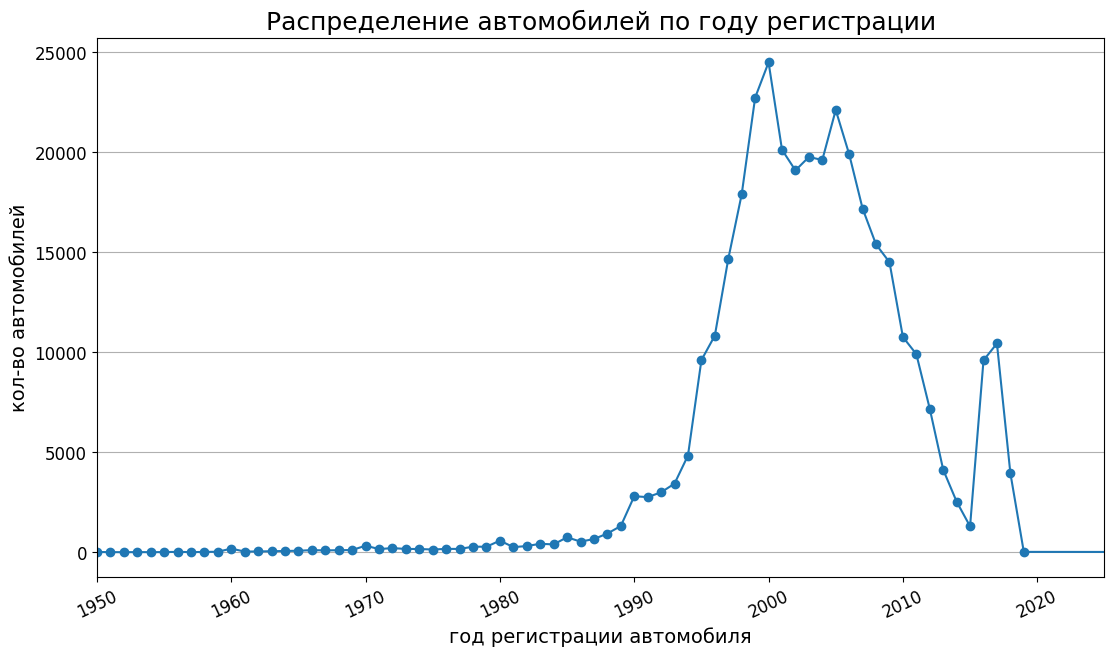

In [12]:
# Построим график методом plot()
autos.groupby('registration_year')['registration_year'].count().plot(
    marker='o',
    xlim = [1950, 2025],
    figsize=(13, 7),
    fontsize=12
)
# Зададим дополнительные параметры графику
plt.title('Распределение автомобилей по году регистрации', fontsize=18)
plt.xlabel('год регистрации автомобиля', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.xticks(rotation=25)
plt.grid(True, axis='y')

Итак, с 1990-х годов мы наблюдаем резких рост зарегистрированных автомобилей, пик которых приходится на 2000-й год. Далее наблюдается небольшое падение и рост в 2005 году, после которого наблюдаем сильное падение вплоть до 2015 года, после которого наблюдаем рост в 2016 и 2017 годах и очередное падение в 2018 и 2019 годах.

Столбец `registration_year` содержит аномальные значения. Очистим датасет от аномальных значений и оставим только автомобили, зарегистрированные с 1979 (с 1979 года наблюдаем планомерный рост числа зарегистрированных автомобилей).

Для определения максимального значения даты регистрации сравним максимальным значением столбца `date_crawled` - они должны совпадать, так как автомобиль не должен быть зарегистрирован после даты выгрузки. 

In [13]:
# Выведем максимальное значение даты выгрузки
autos['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Итак, крайняя дата выгрузки была в 2016 году, поэтому максимальный год регистрации в столбце `registration_year` оставим 2016 год.

In [14]:
# Оставим только автомобили, зарегистрированные с 1979 по 2016 год.
autos = autos.query('1979 <= registration_year <= 2016')

**Рассмотрим признак `price` — стоимость автомобиля в евро.**

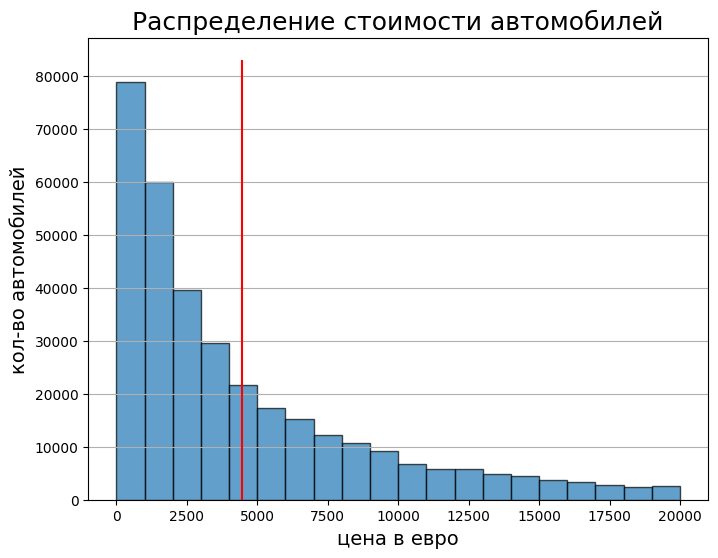

,count,mean,std,min,25%,50%,75%,max
price,336666.0,4448.79,4527.27,0.0,1099.0,2750.0,6499.0,20000.0


In [15]:
# Построим гистограмму 
autos['price'].hist(bins=20, figsize=(8,6), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(autos['price'].mean(), ymin=0, ymax=83000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение стоимости автомобилей', fontsize=18)
plt.xlabel('цена в евро', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.grid(False, axis='x')
plt.show()


# Выведем описательные статистики 
round(autos['price'].describe().to_frame().T, 2)

Итак, на графике мы видим обратную зависимость - с ростом стоимости автомобиля уменьшается их кол-во. Средняя цена авто составляет 4400 евро. Однако для довольно существенной части авто стоимость авто околонулевая. Проверим для каких авто цена составляет менее 100 евро. 

In [16]:
# Отберем авто стоимостью менее 100 евро
autos.query('price < 100')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,unknown,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
115,2016-03-20 18:53:27,0,small,1999,unknown,0,unknown,5000,0,petrol,volkswagen,unknown,2016-03-20,0,37520,2016-04-07 02:45:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09,0,91301,2016-04-06 22:15:32


У нас вышло, что для почти 13 тыс автомобилей цена составляет менее 100 евро. Среди данных авто встречается даже свежие автомобили 2017 года с ценой 0 евро. Для обучения модели оставим только автомобили стоимостью более 100 евро (в 2019 году на вторичном рынке Германии возможно было найти бюджетные варианты автомобилей стоимостью около 100 евро, как правило это были автомобили бюджетные авто 90-х годов, поэтому в качестве объективного минимума возьмем стоимость в 100 евро). 

In [17]:
# Оставим авто стоимостью более 100 евро
autos = autos.query('price >= 100')

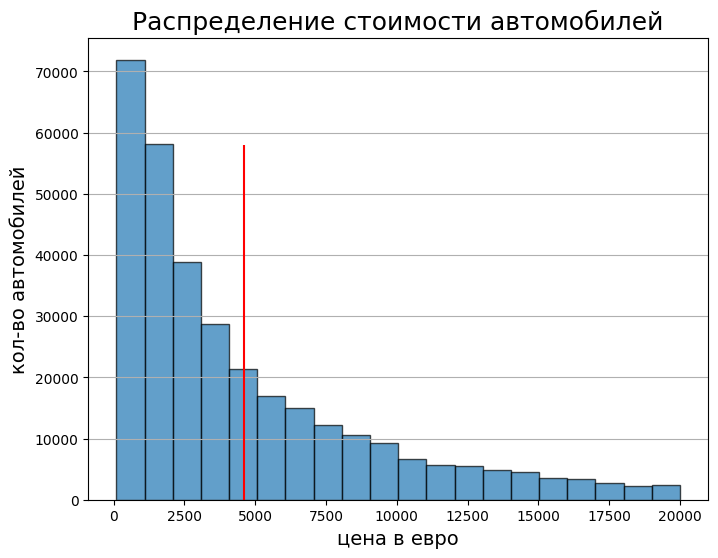

,count,mean,std,min,25%,50%,75%,max
price,324564.0,4614.46,4527.35,100.0,1200.0,2950.0,6600.0,20000.0


In [18]:
# Построим гистограмму 
autos['price'].hist(bins=20, figsize=(8,6), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(autos['price'].mean(), ymin=0, ymax=58000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение стоимости автомобилей', fontsize=18)
plt.xlabel('цена в евро', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.grid(False, axis='x')
plt.show()


# Выведем описательные статистики 
round(autos['price'].describe().to_frame().T, 2)

Итак, график так же имеет обратную зависимость: с ростом цены авто сокращается их кол-во. Целевой признак имеет нормальное распределение со смещением вправо. Средняя цена авто теперь составляет 4600 евро. 

**Рассмотрим признак `power` — мощность (л. с.).**

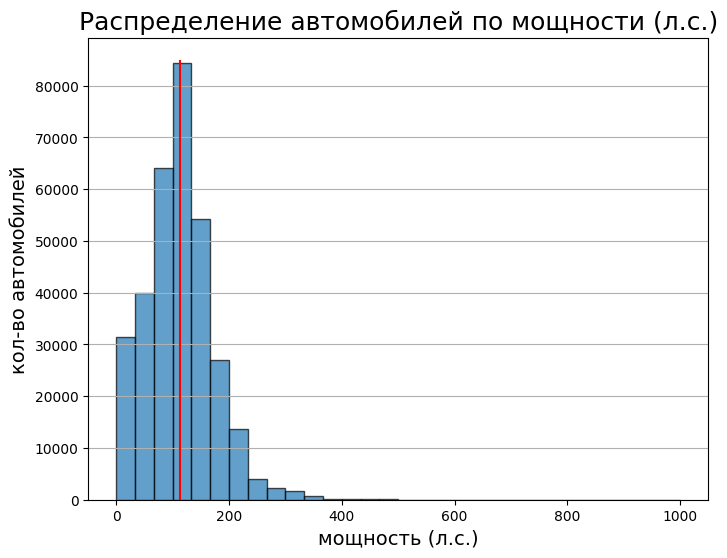

,count,mean,std,min,25%,50%,75%,max
power,324564.0,112.63,183.74,0.0,73.0,105.0,143.0,20000.0


In [19]:
# Построим гистограмму 
autos['power'].hist(bins=30, figsize=(8,6), alpha=0.7, edgecolor='black', range=[0, 1000])

# Отобразим среднее
plt.vlines(autos['power'].mean(), ymin=0, ymax=85000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение автомобилей по мощности (л.с.)', fontsize=18)
plt.xlabel('мощность (л.с.)', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.grid(False, axis='x')
plt.show()


# Выведем описательные статистики 
round(autos['power'].describe().to_frame().T, 2)

Итак, столбец `power` имеет аномальные значения - у автомобилей присутствует мощность 0 л.с., а так же 20000 л.с. Как правило мощностью менее 50 л.с. обладали преимущественно авто, выпущенные в 1930-1960-х годах, а мы в свою очередь оставили авто, зарегистрированные с 1979 года. Максимальную мощность ограничим на отметке 650 л.с., так как более высокой мощностью уже обладают спорткары - авто более высокой ценовой категории.

Итак, мы получили всего один тип авто - это bmw m-серии мощьнотью 507 л.с.

In [20]:
autos = autos.query('50 <= power <= 650')

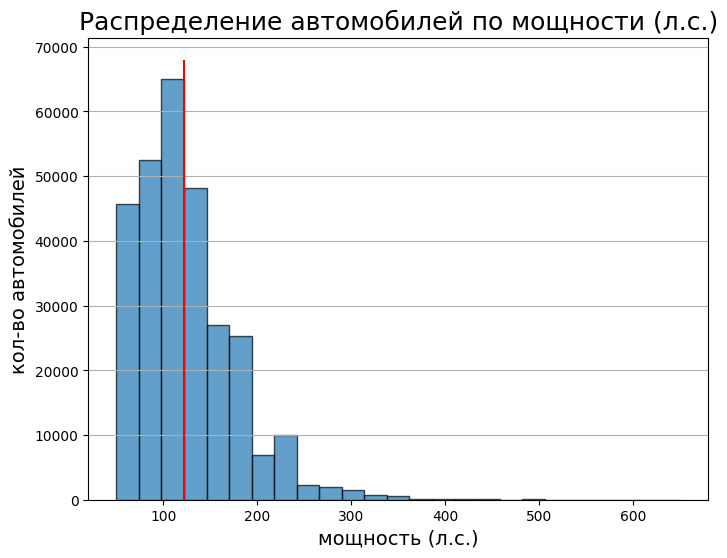

,count,mean,std,min,25%,50%,75%,max
power,288533.0,122.2,53.23,50.0,80.0,115.0,150.0,650.0


In [21]:
# Построим гистограмму 
autos['power'].hist(bins=25, figsize=(8,6), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(autos['power'].mean(), ymin=0, ymax=68000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение автомобилей по мощности (л.с.)', fontsize=18)
plt.xlabel('мощность (л.с.)', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.grid(False, axis='x')
plt.show()


# Выведем описательные статистики 
round(autos['power'].describe().to_frame().T, 2)

Итак, мы имеем график с нормальным распределением со смещением вправо. Средняя мощность автомобиля составляет 122 л.с. График так же имеет обратную зависимость после отметки 150 л.с. - чем больше мощность, тем меньше кол-во автомобилей. Авто с мощностью более 250 л.с. крайне малочисленны - как правило такой мощностью обладают спорткары или премиальные автомобили.

In [22]:
# Напишем собственную функцию, которая будет строить график для дискретных и категориальных признаков
def count_plot(data, column):
    try: 
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=data, order=data[column].value_counts().index)
        plt.title(f'Распределение признака {column}', fontsize=18)
        plt.xlabel(column, fontsize=14)
        plt.ylabel('кол-во автомобилей', fontsize=14)
        plt.show()
    except:
        print ('График недоступен, проверьте вводимые данные')

**Рассмотрим признак `vehicle_type` — тип автомобильного кузова.**

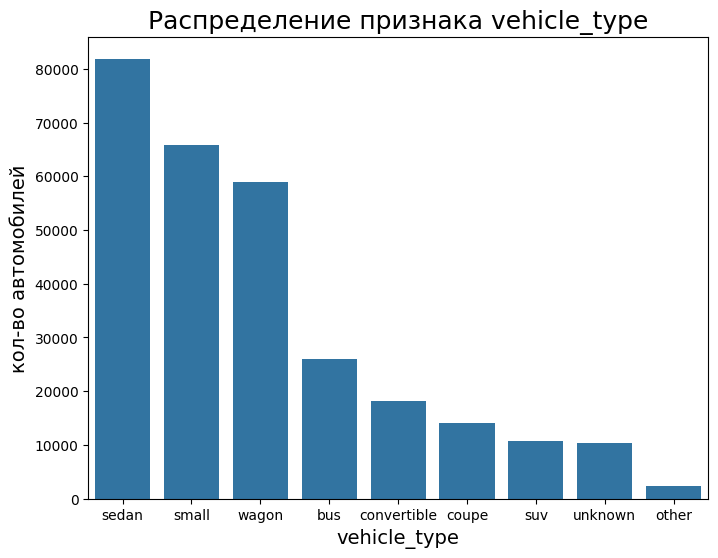

In [23]:
# Построим график
count_plot(autos, 'vehicle_type')

Итак, среди продаваемых автомобилей наиболее популярны автомобили в кузове `sedan` - седан, в кузове `small` - компактные авто, а также в кузове `wagon` - универсал. Наименьшей популярностью пользуются авто в кузове `suv` - кроссоверы и внедорожники и `other` - прочие. Категорией `unknown` мы ранее заполнили пропуски. 

**Рассмотрим признак `fuel_type` — тип топлива.**

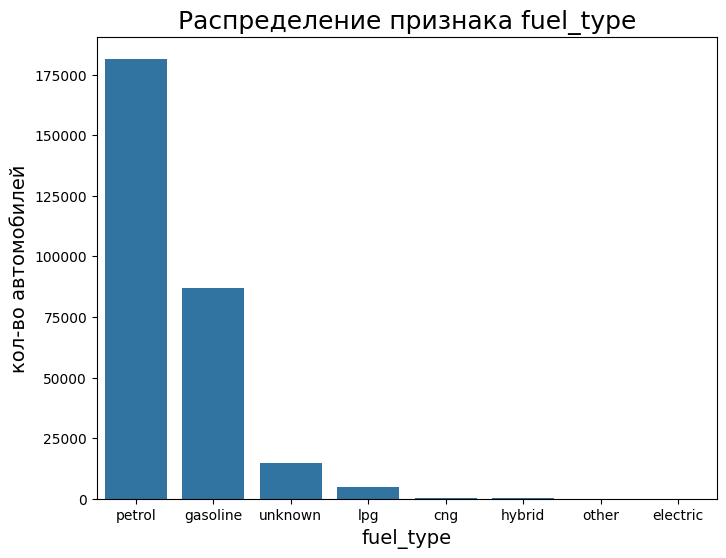

In [24]:
# Построим график
count_plot(autos, 'fuel_type')

Итак, практически все автомобили используют топливо `petrol` и `gasoline` - это бензин (`petrol` это название бензина в США, а `gasoline` - название бензина в Великобритании, Индии и некоторых других странах). Поэтому мы можем объединить данные категории в одну, заменив название `gasoline` на `petrol`. 

In [25]:
# Заменим название 'gasoline' на 'petrol'
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

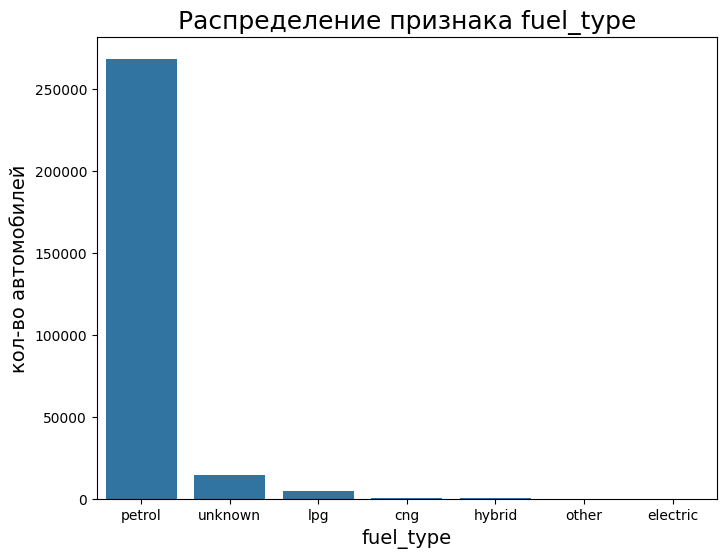

In [26]:
# Построим график
count_plot(autos, 'fuel_type')

Итак, самое популярное топливо `petrol` - бензин. Категорией `unknown` мы ранее заполнили пропуски. Все остальные виды топлива крайне малочисленны. 

**Рассмотрим признак `registration_month` — месяц регистрации автомобиля.**

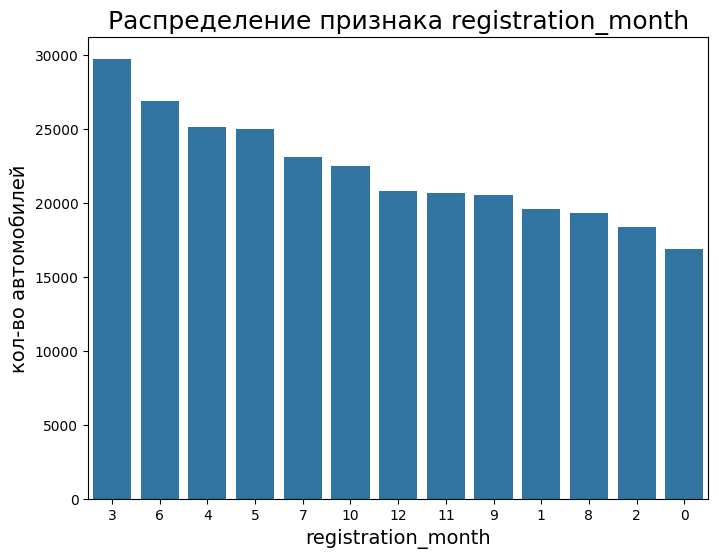

In [27]:
# Построим график
count_plot(autos, 'registration_month')

Итак, наибольшее число автомобилей было зарегистрировано в период с марта по июль (в данный диапазон входят месяца с номерами `3`, `6`, `4`, `5`, `7` на графике).

Присутствует месяц регистрации авто - `0`. При этом все порядковые номера месяцев присутствуют на графике и всего с учетом "нулевого" месяца у нас получается в итоге 13 месяцев. Возможно имеется ошибка в способе заполнения данных в текущем столбце - данную информацию следует уточнить. 

**Рассмотрим признак `brand` — марка автомобиля.**

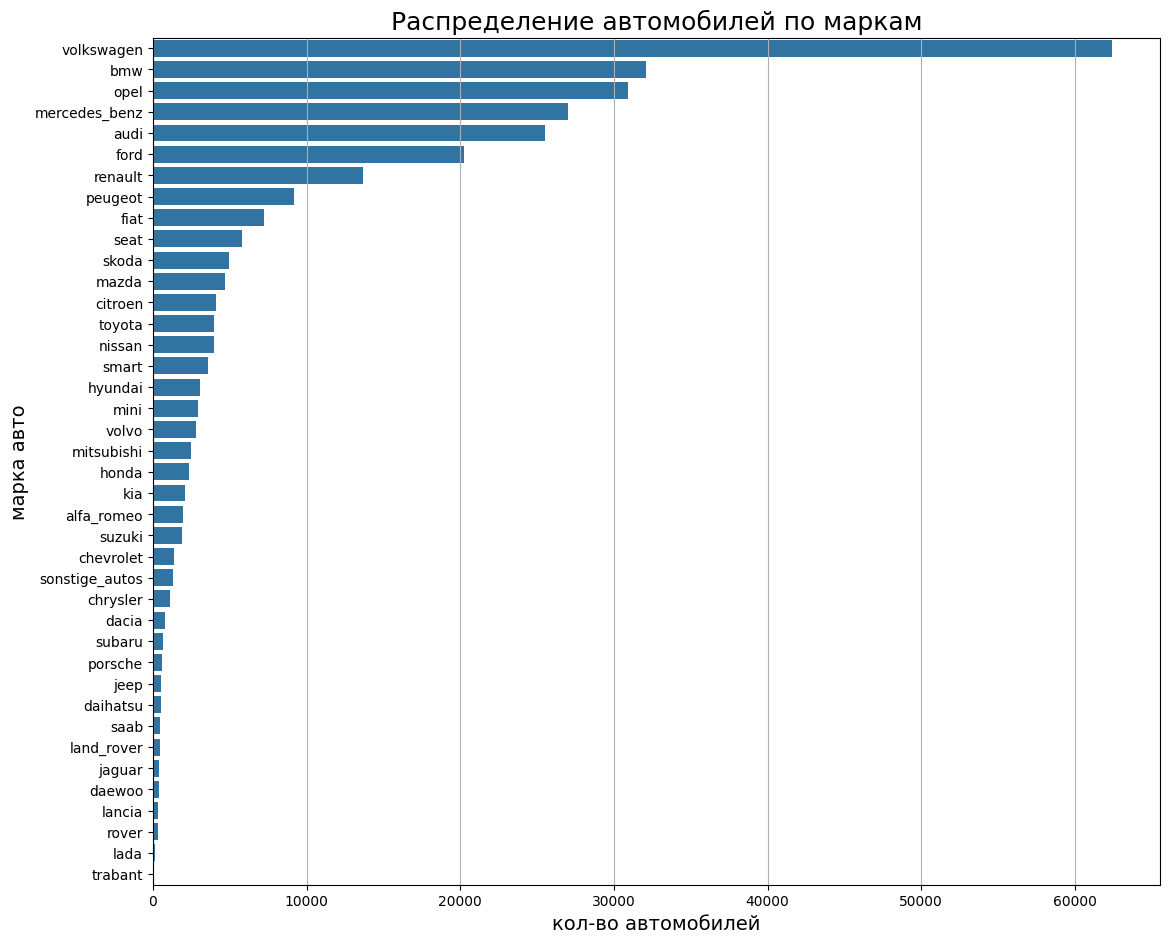

In [28]:
# Построим график
plt.figure(figsize=(13, 11))
sns.countplot(data = autos, y= 'brand', order=autos['brand'].value_counts().index)
plt.title('Распределение автомобилей по маркам', fontsize=18)
plt.xlabel('кол-во автомобилей', fontsize=14)
plt.ylabel('марка авто', fontsize=14)
plt.grid(True, axis='x')
plt.show()

Итак, топ 5 авто представляют собой автомобили немецких брендов, такие как: `volkswagen`, `opel`, `bmw`, `mercedes-benz` и `audi`. Наименее популярны отечественные автомобили марки `lada`. 

**Рассмотрим признак `model` — модель автомобиля.**

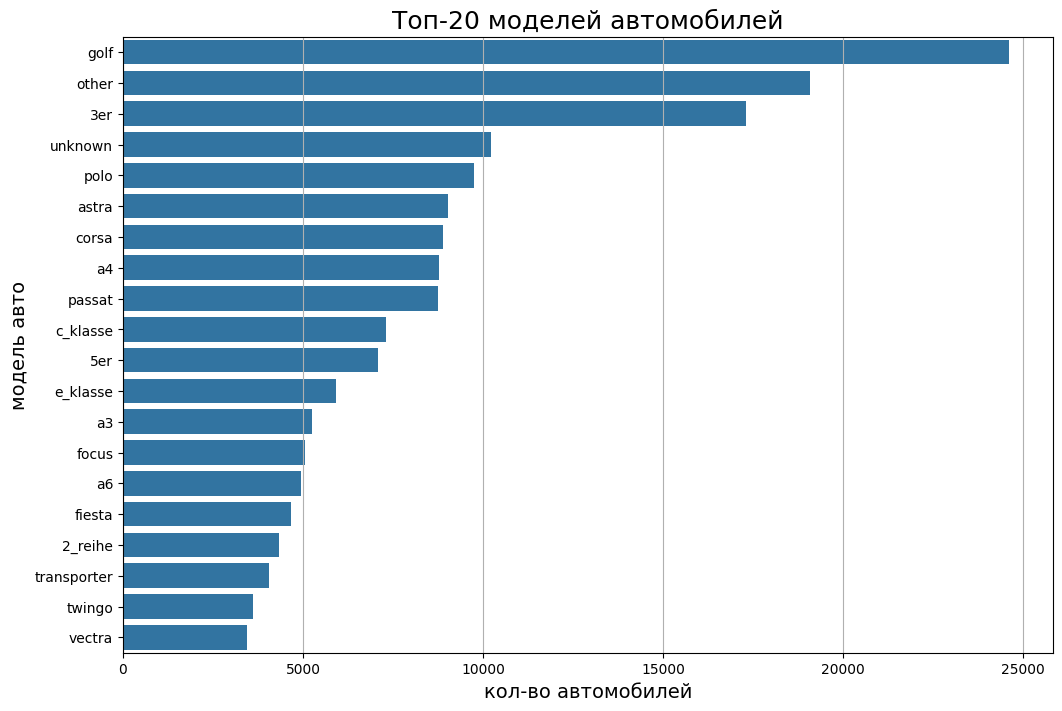

In [29]:
# Построим график
plt.figure(figsize=(12, 8))
sns.countplot(data = autos, y= 'model', order=autos['model'].value_counts().head(20).index)
plt.title('Топ-20 моделей автомобилей', fontsize=18)
plt.xlabel('кол-во автомобилей', fontsize=14)
plt.ylabel('модель авто', fontsize=14)
plt.grid(True, axis='x')
plt.show()

Так как моделей авто крайне много, мы вывели Топ-20 самых популярных моделей авто. Наиболее популярная модель `golf` бренда `volkswagen`. Так же в топе снова присутствуют автомобили немецких брендов такие как модель `3er` бренда `bmw`, модель `polo` бренда `volkswagen`, модели `corsa` и `astra` бренда `opel`, модель `passat` бренда `volkswagen`, модель `a4` бренда `audi`, модель `c_klasse` бренда `mercedes-benz`. 

Так же для большого кол-ва авто марка модели не определена `other`, а так же категорией `unknown` мы ранее заполнили пропуски.

**Рассмотрим признак `kilometer` — пробег (км).**

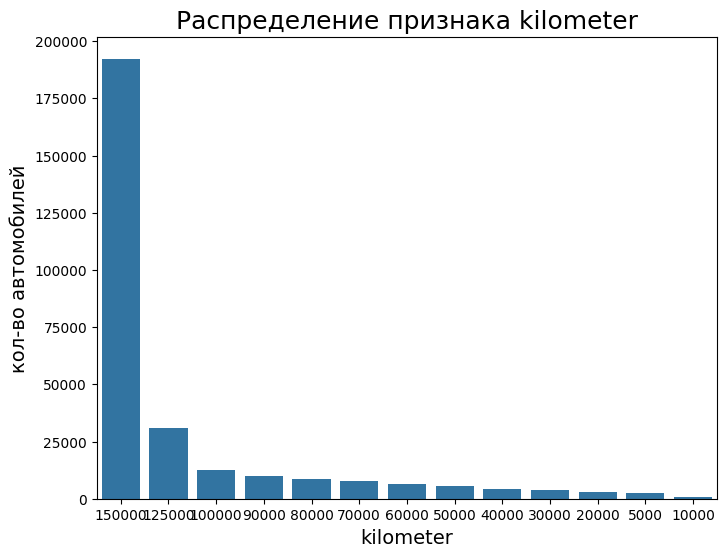

In [30]:
# Построим график
count_plot(autos, 'kilometer')

Итак, столбец `kilometer` имеет дискретные данные. Наибольшая группа автомобилей имеет пробег 150 000 км. Самая малочисленная группа авто с пробегом 10 000 км. На всем графике мы можем наблюдать прямую зависимость: с уменьшением пробега уменьшаяется и кол-во автомобилей. 

**Рассмотрим признак `number_of_pictures` — количество фотографий автомобиля.**

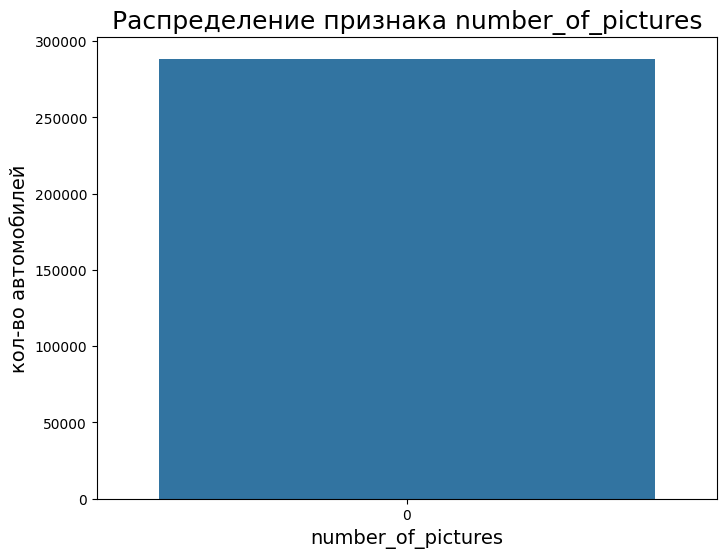

,count,mean,std,min,25%,50%,75%,max
number_of_pictures,288533.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Построим график
count_plot(autos, 'number_of_pictures')


# Выведем описательные статистики 
round(autos['number_of_pictures'].describe().to_frame().T, 2)

Итак, столбец `number_of_pictures` не имеет значений и состоит из одних нулей. Возможно сервис не предполагает наличие фото автомобилей или в сервисе имеется проблема. Данную информацию следует передать в отдел разработки. Данный столбец следует исключить при обучении моделей. 

In [32]:
# Напишем собственную функцию, которая будет строит круговые диаграммы для категориальных признаков
def pie_category(data, column):
    try:
        data.groupby(column)[column].count().plot(
            kind='pie', 
            ylabel='', 
            autopct='%.0f%%', 
            figsize=(6,6), 
            fontsize=12), 
        plt.title(f'Соотношение признаков в столбце {column}', fontsize=16);
    except:
        print ('График недоступен, проверьте вводимые данные')

**Рассмотрим признак `gearbox` — тип коробки передач.**

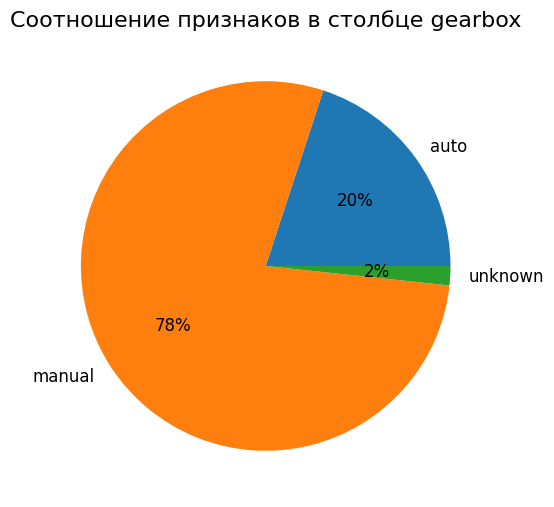

In [33]:
# Построим круговую диаграмму
pie_category(autos, 'gearbox')

Итак, у 78 % автомобилей ручная коробка передач `manual`, у 20 % автомобилей коробка передач - автоматическая `auto`. Для 2 % авто тип коробки передач неизвестен (ранее мы пропуски заполнили значением `unknown`).

**Рассмотрим признак `repaired` — была машина в ремонте или нет.**

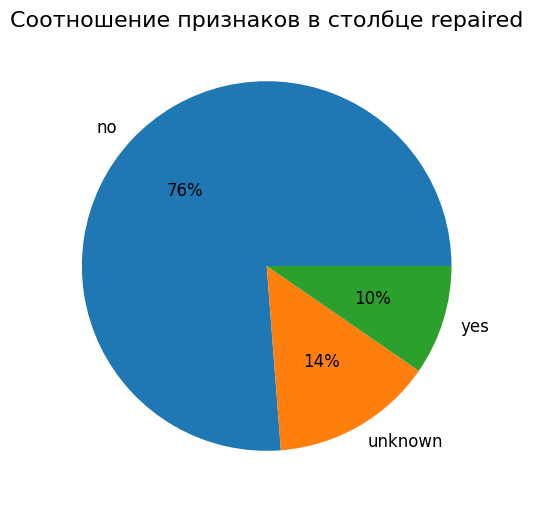

In [34]:
# Построим круговую диаграмму
pie_category(autos, 'repaired')

Итак, 76 % автомобилей не находились в ремонте, тогда как у 10 % автомобилей производились ремонтные работы. Для 14 % авто неизвестно были ли они в ремонте или нет (ранее мы пропуски заполнили значением `unknown`).

**Рассмотрим признак `date_created` — дата создания анкеты.**

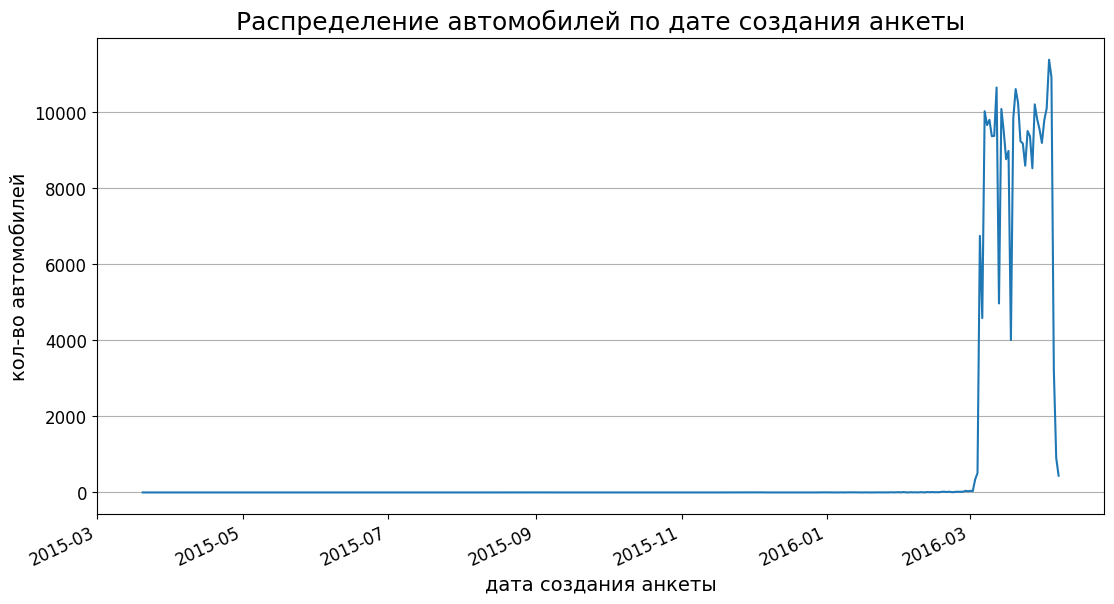

In [35]:
# Построим график методом plot()
autos.groupby('date_created')['date_created'].count().plot(
    figsize=(13, 7),
    fontsize=12
)
# Зададим дополнительные параметры графику
plt.title('Распределение автомобилей по дате создания анкеты', fontsize=18)
plt.xlabel('дата создания анкеты', fontsize=14)
plt.ylabel('кол-во автомобилей', fontsize=14)
plt.xticks(rotation=25)
plt.grid(True, axis='y')

Итак, на гарфике можно отметить, что анкеты были созданы в период с марта 2016 года по май 2016 года. 

### Промежуточный вывод:

Проведена подготовка данных датасета `autos`, а именно:

- Наименования столбцов приведены к змеиному регистру;
- Пропуски в столбцах `vehicle_type`, `gearbox, model`, `fuel_type`, `repaired` заполнены значением `unknown`;
- Столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired` приведены к типу `category`;
- Удалены 4 строки явных дубликатов;
- Удалены аномальные значения в столбцах `registration_year` и `price`.
- В столбце `fuel_type` объединили данные категории `gasoline` на `petrol` в одну - `petrol`, так как они обозначают одно и тоже.

Проведен исследовательский анализ данных и выявлено следующее:

- Целевой признак `price` имеет нормальное распределение со смещением вправо, а также обратную зависимость: с ростом цены авто сокращается их кол-во. Средняя цена авто составляет 4900 евро. 
- В столбце `registration_year` с 1990-х годов мы наблюдаем резких рост зарегистрированных автомобилей, пик которых приходится на 2000-й год. Сильное падение в числа зарегестрированных авто приходится на 2018 и 2019 гг.
- Столбец `power` имеет нормальное распределение со смещением вправо. Средняя мощность автомобиля составляет 121 л.с. График так же имеет обратную зависимость после отметки 150 л.с. - чем больше мощность, тем меньше кол-во автомобилей. 
- В столбце `vehicle_type` cреди продаваемых автомобилей наиболее популярны автомобили в кузове `sedan` - седан, в кузове `small` - компактные авто, а также в кузове `wagon` - универсал. Наименьшей популярностью пользуются авто в кузове `suv` - кроссоверы и внедорожники и `other` - прочие.
- В столбце `fuel_type` практически все автомобили имеют вид топлива `petrol` - бензин.
- В столбце `registration_month` наибольшее число автомобилей было зарегистрировано в период с марта по июль. Так же возможно имеется ошибка в способе заполнения данных в текущем столбце, так как для большинства автомобилей месяц регистрации авто - `0`. При этом все порядковые номера месяцев присутствуют на графике и всего с учетом "нулевого" месяца у нас получается в итоге 13 месяцев. Данную информацию следует уточнить у соответствующего подразделения, отвечающего за сбор данных. 
- В столбце `brand` топ 5 авто представляют собой автомобили немецких брендов, такие как: `volkswagen`, `opel`, `bmw`, `mercedes-benz` и `audi`. Наименее популярны отечественные автомобили марки `lada`. 
- В столбце `model` наиболее популярная модель `golf` бренда `volkswagen`. Так же популярны автомобили немецких брендов такие как модель `3er` бренда `bmw`, модель `polo` бренда `volkswagen`, модели `corsa` и `astra` бренда `opel`, модель `passat` бренда `volkswagen`, модель `a4` бренда `audi`, модель `c_klasse` бренда `mercedes-benz`.
- Столбец `kilometer` имеет дискретные данные. Наибольшая группа автомобилей имеет пробег 150 000 км. Самая малочисленная группа авто с пробегом 10 000 км. Имеется прямая зависимость: с уменьшением пробега уменьшается и кол-во автомобилей. 
- Столбец `number_of_pictures` не имеет значений и состоит из одних нулей. Возможно сервис не предполагает наличие фото автомобилей или в сервисе имеется проблема. Данную информацию следует передать в отдел разработки. Данный столбец следует исключить при обучении моделей. 
- В столбце `gearbox` у 78 % автомобилей ручная коробка передач `manual`, у 20 % автомобилей коробка передач - автоматическая `auto`.
- В столбце `repaired` у 75 % автомобилей не находились в ремонте, тогда как у 10 % автомобилей производились ремонтные работы.
- В столбце `date_created` анкеты были созданы в период с марта 2016 года по май 2016 года.

## Обучение моделей

Преобразуем столбцы `date_crawled`, `date_created`, `last_seen` в формат `unix time`.

In [36]:
# Добавим новые преобразованные столбцы в формате unix time
autos['date_crawled'] = autos['date_crawled'].apply(lambda x: x.timestamp())

autos['date_created'] = autos['date_created'].apply(lambda x: x.timestamp())

autos['last_seen'] = autos['last_seen'].apply(lambda x: x.timestamp())

Построим матрицу **корреляции Фи**.

/opt/anaconda3/lib/python3.12/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2035861. Are interval variables set correctly?
  warnings.warn(


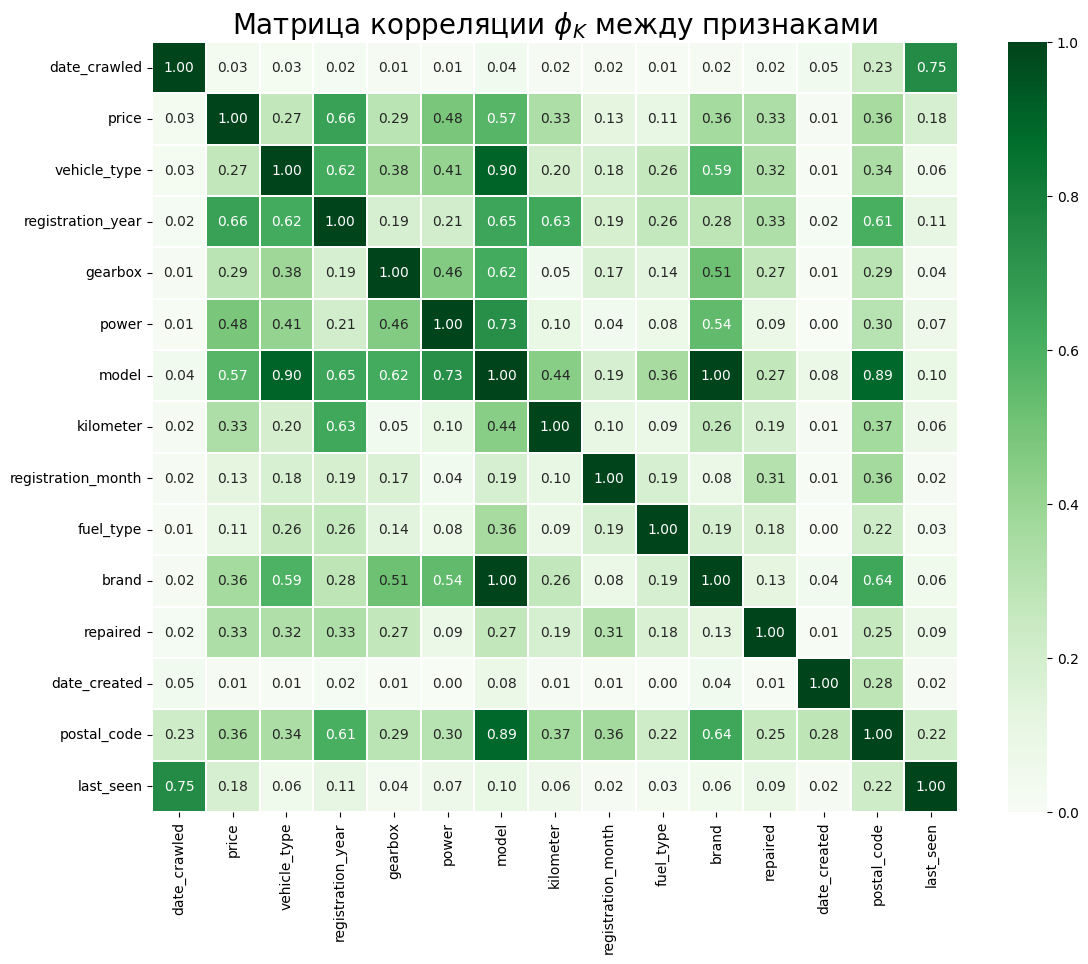

In [37]:
# Построим матрицу корреляции с помощью тепловой карты heatmap
plt.figure(figsize=(13, 10))

sns.heatmap(autos.phik_matrix(interval_cols=
                              [
                                  'price', 'power', 'date_crawled', 
                                  'date_created', 'last_seen'
                              ]
                             ), annot=True, fmt='.2f', cmap='Greens', linewidths=0.1)

plt.title('Матрица корреляции $\phi_K$ между признаками', fontsize=20)
plt.show()

Темные тона говорят о сильной связи, а светлые — о слабой. Чем ближе значение к 1, тем сильнее связь. 

**С целевым признаком `price`**:

*Сильную связь (Phik > 0.6)* имеют входные признаки:
- `registration_year` (коэф. 0.66) -  год регистрации автомобиля

*Заметную связь (0.4 < Phik ≤ 0.6)* имеют входные признаки: 
- `model` (коэф. 0.57) - модель автомобиля
- `power` (коэф. 0.48) - мощность (л. с.)

*Умеренную связь (0.2 < Phik ≤ 0.4)* имеют входные признаки:
- `brand` (коэф. 0.36) - марка автомобиля
- `postal_code` (коэф. 0.36) - почтовый индекс владельца анкеты (пользователя)
- `kilometer` (коэф. 0.33) - пробег (км)
- `repaired` (коэф. 0.33) - была машина в ремонте или нет
- `gearbox` (коэф. 0.29) - тип коробки передач
- `vehicle_type` (коэф. 0.27) - тип автомобильного кузова


*Слабую связь (0 ≤ Phik ≤ 0.2)* имеют входные признаки:
- `last_seen` (коэф. 0.18) - дата последней активности пользователя
- `registration_month` (коэф. 0.13) - месяц регистрации автомобиля
- `fuel_type`  (коэф. 0.11) - тип топлива
- `date_crawled` (коэф. 0.03) - дата скачивания анкеты из базы
- `date_created` (коэф. 0.01) - дата создания анкеты

Имеются следующие **мультикоррелирующие** входные признаки: 
- `model` и `brand` (коэф. 1)

Входной признак `model` имеет более высокую связь с целевым признаком `price`, нежели входной признак `brand`, поэтому перед обучением удалим столбец `brand`. Так же следует удалить входящий признак `number_of_pictures` - так как он содержит одни нули и входящий признак `date_crawled` - так как у него практически отсутствует корреляция с целевым признаком `price`. 

### Обучим модель линейной регрессии `LinearRegression`

Разобьем данные на тренировочную и валидационную выборки.

In [38]:
# Сохраним значение random_state = 42 в переменную RANDOM_STATE
RANDOM_STATE = 42

Для обучения модели удалим из датасета следующие ненужные столбцы:

- `date_crawled` - практически отсутствует корреляция с целевым признаком;
- `registration_month` - практически отсутствует корреляция с целевым признаком и более показательный для модели будет столбец `registration_year`, поэтому столбец с месяцем можем удалить;
- `brand` - мультикоррелирующий входной признак; 
- `number_of_pictures` - содержит одни нули.

In [39]:
# Сохраним в новый датасет данные без ненужных столбцов
autos_copy = autos.drop(['date_crawled', 'registration_month', 
                         'brand', 'number_of_pictures'], axis=1)

In [40]:
# Проверим датасет на наличие дубликатов
print('Кол-во строк дубликатов:', autos_copy.duplicated().sum())

Кол-во строк дубликатов: 88


Итак, после удаления столбцов, у нас появилось 88 строк дубликатов, очистим от них дадасет.

In [41]:
# Удалим явные строки-дубликаты
autos_copy = autos_copy.drop_duplicates()

print('Кол-во строк дубликатов:', autos_copy.duplicated().sum())

Кол-во строк дубликатов: 0


In [42]:
# Сохраним входные признаки в переменную X
X = autos_copy.drop('price', axis=1)

In [43]:
# Сохраним целевой признак в переменную y
y = autos_copy['price']

In [44]:
# Разделим на тренировочную и валидационную и тестовую выборки
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=RANDOM_STATE
)

In [45]:
# Разделим на валидационную и тестовую выборки
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test_valid, 
    y_test_valid, 
    test_size=0.5, 
    random_state=RANDOM_STATE
)

Создадим списки с названиями признаков для кодирования и масштабирования.

In [46]:
# В переменную ohe_columns запишем категориальные признаки для OneHotEncoder
ohe_columns = ['vehicle_type', 'gearbox', 
               'model', 'fuel_type', 'repaired']

In [47]:
# В переменную num_columns запишем количественные признаки
num_columns = ['registration_year', 'power', 'kilometer', 
               'date_created', 'postal_code', 'last_seen']

Cоздадим пайплайн для подготовки данных кодированием `OneHotEncoder`

In [48]:
# Создадим пайплайн ohe_pipe для кодирования OneHotEncoder
ohe_pipe = Pipeline(
    [
        ('simpleimputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')), 
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

Создадим пайплайн для масштабирования данных.

In [49]:
# Создадим пайплайн num_pipe для масштабирования данных
num_pipe = Pipeline(
    [
        ('simpleimputer_num', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-9999)),
        ('num', StandardScaler())
    ]
)

Создадим общий пайплайн для подготовки данных.

In [50]:
# Создадим общий пайплайн data_pipe для подготовки данных
data_pipe = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns), 
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

Cоздадим итоговый пайплайн: подготовка данных и модель.

In [51]:
# Cоздадим итоговый пайплайн final_pipe: подготовка данных и модель
final_pipe = Pipeline(
    [
        ('preparation', data_pipe), 
        ('model', LinearRegression())
    ]
)

Cоздадим список с гиперпараметрами для `GridSearchCV`

In [52]:
# Cоздадим список с гиперпараметрами
param_grid = [
    {
        'preparation__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    } 
]

Подбор гиперпараметров будем проводить с помощью `GridSearchCV`, а для оценки качества модели будем использовать метрику `RMSE`.

In [53]:
# Используем GridSearchCV
grid_search = GridSearchCV(
    final_pipe, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

Обучим наши модели с гиперпараметрами и выведем лучшую модель и ее метрику.

In [54]:
# Обучаем модели
%time grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search.best_params_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', -grid_search.best_score_)

CPU times: user 1.1 s, sys: 101 ms, total: 1.2 s
Wall time: 6.06 s
Лучшая модель и её параметры: {'preparation__num': MinMaxScaler()}
Метрика RMSE лучшей модели на кросс-валидации: 2433.812655278814


Проверим работу модели на валидационной выборке.

In [55]:
# Получим предсказания на валидационной выборке
%time predict_lg = grid_search.predict(X_valid)

print ('Метрика RMSE лучшей модели на валидационной выборке:', 
       round(root_mean_squared_error(y_valid, predict_lg)))

CPU times: user 57.4 ms, sys: 8.41 ms, total: 65.8 ms
Wall time: 65.5 ms
Метрика RMSE лучшей модели на валидационной выборке: 2472


Проверим нашу модель на адекватность, сравнив качество её предсказаний с качеством константной модели `DummyClassifier`.

In [56]:
# Обучим модель DummyRegressor
dummy_reg = DummyRegressor()

%time dummy_reg.fit(X_train, y_train)

# Выведем метрику SMAPE
print(f'Метрика RMSE константной модели на валидационной выборке:', round(
    root_mean_squared_error(y_valid, dummy_reg.predict(X_valid))))

CPU times: user 282 μs, sys: 242 μs, total: 524 μs
Wall time: 481 μs
Метрика RMSE константной модели на валидационной выборке: 4635


Итак, по итогам работы `GridSearchCV` мы получили модель `LinearRegression` с методом масштабирования `MinMaxScaler()`. Качество нашей модели выше, чем у константной модели `DummyClassifier` (`RMSE` нашей модели 2471 против `RMSE` константной модели в 4635). 

- Метрика `RMSE` на кросс-валидации лучшей модели составила 2434, а на валидационной выборке — 2472, что говорит о низком разбросе модели. Значение метрики лучшей модели удовлетворяет условию заказчика (значение метрики `RMSE` должно быть меньше 2500) 
- Время обучения модели `LinearRegression` составило: 6 s на первом запуске, 5.84 s на втором запуске, 6.06 s на третьем запуске
- Время предсказания модели `LinearRegression` составило 65 ms на первом запуске, 69 ms на втором запуске, 65 ms на третьем запуске 

### Обучим модель градиентного бустинга `LightGBM`

Создим базовую модель.

In [57]:
# Зададим базовые параметры модели
lgb_model = lgb.LGBMRegressor(
    objective='regression', 
    metric='rmse', 
    n_estimators=100, 
    learning_rate=0.1,
)

Cоздадим список с гиперпараметрами для `GridSearchCV`

In [58]:
# Cписок с гиперпараметрами
param_grid_lgb = {
    'learning_rate': [0.05, 0.1], 
    'n_estimators': [50, 100], 
    'max_depth': [5, 15],
}

In [59]:
# Создаем GridSearchCV
grid_search_lgb = GridSearchCV(
    lgb_model, 
    param_grid_lgb, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    verbose=10,
    n_jobs=-1
)

In [60]:
# Обученим модели с поиском лучших параметров
%time grid_search_lgb.fit(X_train, y_train, categorical_feature=ohe_columns)

print('Лучшая модель и её параметры:', grid_search_lgb.best_params_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', -grid_search_lgb.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START learning_rate=0.05, max_depth=5, n_estimators=50............
[CV 4/5; 1/8] START learning_rate=0.05, max_depth=5, n_estimators=50............
[CV 5/5; 1/8] START learning_rate=0.05, max_depth=5, n_estimators=50............
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 138453, number of used features: 11
[CV 3/5; 1/8] START learning_rate=0.05, max_depth=5, n_estimators=50............
[LightGBM] [Info] Start training from score 4900.741811
[CV 1/5; 2/8] START learning_rate=0.05, max_depth=5, n_estimators=100...........
[CV 2/5; 1/8] START learning_rate=0.05, max_depth=5, n_estimators=50............
[CV 3/5; 2/8] START learning_rate=0.05, max_

Проверим работу модели на валидационной выборке.

In [61]:
# Получим предсказания на валидационной выборке
%time predict_lgb = grid_search_lgb.predict(X_valid)

print ('Метрика RMSE лучшей модели на валидационной выборке:', 
       round(root_mean_squared_error(y_valid, predict_lgb)))

CPU times: user 533 ms, sys: 22.5 ms, total: 555 ms
Wall time: 73.6 ms
Метрика RMSE лучшей модели на валидационной выборке: 1582


Итак, по итогам работы `GridSearchCV` мы получили модель `LGBMRegressor` со следующими гиперпараметрами: `learning_rate: 0.1, max_depth: 15, n_estimators: 100`. 

- Метрика `RMSE` на кросс-валидации лучшей модели составила 1567, а на валидационной — 1582, что говорит о низком разбросе модели. Значение метрики лучшей модели удовлетворяет условию заказчика (значение метрики `RMSE` должно быть меньше 2500) 
- Время обучения и поиска лучших гиперпараметров модели `LGBMRegressor` составило 29 s на первом запуске, 28 s на втором запуске, 25 s на третьем запуске
- Время предсказания модели `LGBMRegressor` составило 103 ms на первом запуске, 77 ms на втором запуске, 73 ms на третьем запуске 

## Анализ моделей

Мы получили две модели со следующими характеристиками:


1. **Модель `LinearRegression`** 

   - Метрика `RMSE` на валидационных данных составила 2472;
   - Среднее время обучения модели `LinearRegression` составило 6 s;
   - Среднее время предсказания модели `LinearRegression` составило 66 ms.


2. **Модель `LGBMRegressor`** с гиперпараметрами: `learning_rate: 0.1, max_depth: 15, n_estimators: 100`. 

   - Метрика `RMSE` на валидационных данных составила 1582;
   - Среднее время обучения и поиска лучших гиперпараметров модели `LGBMRegressor` составило 27 s;
   - Среднее время предсказания модели `LGBMRegressor` составило 84 ms.

Итак, сравнивая важные для заказчика мы можем выделить следующее:

- Наилучшая метрика `RMSE` у модели `LGBMRegressor`, она в 1,5 раза превышает лучшую метрику модели `LinearRegression`.
- Наилучшее среднее время обучения у модели `LinearRegression`, однако, для модели `LGBMRegressor` мы перебирали 6 гиперпараметров, тогда как для `LinearRegression` мы подбирали только способы масштабирования. Если сократить кол-во гиперпарметров у модели `LGBMRegressor`, то скорость обучения возрастет. 
- Наилучшее среднее время предсказаний у модели `LinearRegression`, данная модель делает предсказания в 4.5 раза быстрее модели `LGBMRegressor`. 


Итак, у модели `LGBMRegressor` значительно лучше метрика `RMSE`, что позволит более точно определять стоиомость автомобилей в приложении. Модель `LGBMRegressor` уступает модели `LinearRegression` лишь в скорости предсказаний. Однако для пользователей приложения более важным показателем будет точность оценки их автомобилей.

Проверим работу лучшей модели на тестовой выборке.

In [63]:
# Получим предсказания на тестовой выборке
%time predict_lgb_test = grid_search_lgb.predict(X_test)

print ('Метрика RMSE лучшей модели на тестовой выборке:', 
       round(root_mean_squared_error(y_test, predict_lgb_test)))

CPU times: user 578 ms, sys: 45.2 ms, total: 623 ms
Wall time: 84.7 ms
Метрика RMSE лучшей модели на тестовой выборке: 1560


Итак, на тестовых данных метрика `RMSE` нашей лучшей модели составила 1560. Метрика на кросс-валидации составила 1567, что говорит нам о низком разбросе модели. Метрика `RMSE` лучшей модели на тестовых данных более чем соответствует условию заказчика значение метрики RMSE должно быть меньше 2500).

**Проведем анализ важности признаков модели `LGBMRegressor`. Визуализируем относительную важность признаков на основании их вклада в разбиение деревьев.**

In [64]:
# Сохраним нашу лучшую модель LGBMRegressor
best_model = grid_search_lgb.best_estimator_

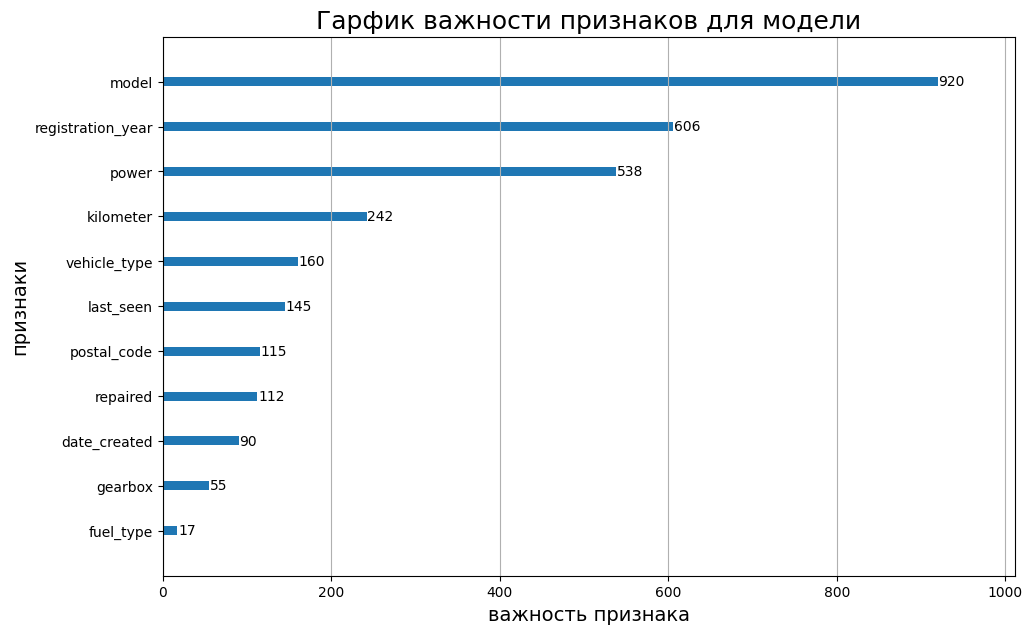

In [65]:
# Построим график важности признаков модели LGBMRegressor
lgb.plot_importance(best_model, max_num_features=11, figsize=(11, 7))  

# Зададим дополнительные параметры графику
plt.title('Гарфик важности признаков для модели', fontsize=18)
plt.xlabel('важность признака', fontsize=14)
plt.ylabel('признаки', fontsize=14)
plt.grid(False, axis='y')
plt.show() 

Итак, наиболее важными для модели `LGBMRegressor` являются следующие признаки (в порядке убывания важности):

- `model` — модель автомобиля;
- `registration_year` — год регистрации автомобиля;
- `power` — мощность (л. с.);
- `kilometer` — пробег (км);
- `vehicle_type` — тип автомобильного кузова.

На качестве этих данных следует обращать внимание при заполнении их пользователями, так как от их качества будет зависеть точность предсказаний стоимости автомобилей в приложении. 

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента</b>

Провел чуть выше проверку на тестовых данных </div> 

### Итоговый вывод:

В ходе выполнения проекта была проделана следующая работа:

**Проведена предобработка данных:**

- Наименования столбцов приведены к змеиному регистру;
- Пропуски в столбцах `vehicle_type`, `gearbox, model`, `fuel_type`, `repaired` заполнены значением `unknown`;
- Столбцы `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired` приведены к типу `category`;
- Удалены 4 строки явных дубликатов;
- Удалены аномальные значения в столбцах `registration_year` и `price`.
- В столбце `fuel_type` объединили данные категории `gasoline` на `petrol` в одну - `petrol`, так как они обозначают одно и тоже.


**Проведен исследовательский анализ данных:**

- Средняя цена авто составляет 4600 евро. 
- С 1990-х годов мы наблюдаем резких рост зарегистрированных автомобилей, пик которых приходится на 2000-й год. 
- Средняя мощность автомобиля составляет 122 л.с. После отметки 150 л.с. - чем больше мощность, тем меньше кол-во автомобилей. 
- Наиболее популярны автомобили в кузове `sedan` - седан, в кузове `small` - компактные авто, а также в кузове `wagon` - универсал. Наименьшей популярностью пользуются авто в кузове `suv` - кроссоверы и внедорожники и `other` - прочие.
- Практически все автомобили имеют вид топлива `petrol` - бензин.
- В столбце `registration_month`  возможно имеется ошибка в способе заполнения данных в текущем столбце, так как для большинства автомобилей месяц регистрации авто - `0`. При этом все порядковые номера месяцев присутствуют на графике и всего с учетом "нулевого" месяца у нас получается в итоге 13 месяцев. Данную информацию следует уточнить у соответствующего подразделения, отвечающего за сбор данных. Наибольшее число автомобилей было зарегистрировано в период с марта по июль.
- Топ 5 авто представляют собой автомобили немецких брендов, такие как: `volkswagen`, `opel`, `bmw`, `mercedes-benz` и `audi`. Наименее популярны отечественные автомобили марки `lada`. 
- Наиболее популярная модель `golf` бренда `volkswagen`. Так же популярны автомобили немецких брендов такие как модель `3er` бренда `bmw`, модель `polo` бренда `volkswagen`, модели `corsa` и `astra` бренда `opel`, модель `passat` бренда `volkswagen`, модель `a4` бренда `audi`, модель `c_klasse` бренда `mercedes-benz`.
- Наибольшая группа автомобилей имеет пробег 150 000 км. Самая малочисленная группа авто с пробегом 10 000 км. Имеется прямая зависимость: с уменьшением пробега уменьшается и кол-во автомобилей. 
- Столбец `number_of_pictures` не имеет значений и состоит из одних нулей. Возможно сервис не предполагает наличие фото автомобилей или в сервисе имеется проблема. Данную информацию следует передать в отдел разработки. Данный столбец следует исключить при обучении моделей. 
- У 78 % автомобилей ручная коробка передач `manual`, у 20 % автомобилей коробка передач - автоматическая `auto`.
- У 76 % автомобилей не находились в ремонте, тогда как у 10 % автомобилей производились ремонтные работы.


**Обучили и проверили модели:**

1. Построили матрицу корреляции Фи. 


2. Для подготовки данных и подбора метода масштабирования для модели линейной регрессии мы подготовили пайпланы.


3. По итогам работы `GridSearchCV` мы получили модель `LinearRegression` с методом масштабирования `MinMaxScaler()` и модель `LGBMRegressor` с гиперпараметрами: `learning_rate: 0.1, max_depth: 15, n_estimators: 100`. 


4. **Лучшей оказалась модель `LGBMRegressor`** с гиперпараметрами: `learning_rate: 0.1, max_depth: 15, n_estimators: 100`:
   - Метрика `RMSE` на тестовых данных составила 1560;
   - Среднее время обучения и поиска лучших гиперпараметров модели `LGBMRegressor` составило 27 s;
   - Среднее время предсказания модели `LGBMRegressor` составило 84 ms.


5. Наиболее важными для модели `LGBMRegressor` являются следующие признаки (в порядке убывания важности):

   - `model` — модель автомобиля;
   - `registration_year` — год регистрации автомобиля;
   - `power` — мощность (л. с.);
   - `kilometer` — пробег (км);
   - `vehicle_type` — тип автомобильного кузова.

   На качестве этих данных следует обращать внимание при заполнении их пользователями, так как от их качества будет    зависеть точность предсказаний стоимости автомобилей в приложении. 